# THE NUMBER OF JUPYTER NOTEBOOK REPOS ON GITHUB

**Keith E. Maull<sup>^1</sup>**

September 18, 2018

1. NCAR Library, National Center for Atmospheric Research

## SUMMARY

In the [prior work](./0_explore_nbrepo_estimate.ipynb) we began a basic exploration of the number of repos that were listed as "Jupyer Notebook" repos (a definition which requires more detail).  In any event, these repos are one's which return data via the Github API with the following query:

```html
/search/repositories?q=language:"Jupyter Notebook"+is:public')
```

We would like to answer a few questions though:

* which of these repos are *top* (by stars) and what is in these repos - is there some interesting pattern about these that might help us understand the remaining repos
* what is the _mix_ and _ratio_ of jupyter notebook files to other files in the repo and what can that help us understand about the actual remaining repos, and is there some pattern with this mix that leads us to understand more about the repos themselves

**USING METADATA**

We'd like to use all this data to inform our metadata explorations and in keeping with the metadata evaluation criterion we're expecting to build upon.

* what are the useful metadata we need to answer useful questions about searching for notebooks?

**NOTE:** As with the last exploration, this code may push the [rate limits](https://developer.github.com/v3/#rate-limiting) of the API, so please put the token in `gh_auth_token.txt` for best reproducibility results.

### PRELIMINARIES

In [1]:
# NOTE: make sure you put your API auth token in gh_auth_token.txt
with open('gh_auth_token.txt'
         ) as fi:
    GH_AUTH_TOKEN = fi.readlines()[0].strip()

In [2]:
# core imports
%matplotlib inline 
import pprint
import time 
import requests
import pandas as pd

def gh_api(url):
    headers = {'Authorization': GH_AUTH_TOKEN}
    r = requests.get(url, headers=headers)

    if r.status_code == 200:
        data = r.json() # dict_keys(['total_count', 'incomplete_results', 'items'])
        return data
    else:
        print("E:{}/{}".format(r.status_code, r.content))

### TOP 30 JUPYER REPOS (>999 STARS)

We must get all Jupyter Notebooks from the API.

In [3]:
data = gh_api('https://api.github.com/search/repositories?q=language:"Jupyter Notebook"+is:public+stars:1000..*')

In [4]:
for r in data['items']:
    print(r.keys())
    break

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'open_issues_count', 'license', 'fork

Let's take the data and make the list which will be transformed to a DF eventually. 

In [5]:
top30data = []
for r in data['items']:
    top30data.append(r)
    print(".", end="")

..............................

In [6]:
top30data[:1]

[{'id': 45986162,
  'node_id': 'MDEwOlJlcG9zaXRvcnk0NTk4NjE2Mg==',
  'name': 'TensorFlow-Examples',
  'full_name': 'aymericdamien/TensorFlow-Examples',
  'private': False,
  'owner': {'login': 'aymericdamien',
   'id': 10386605,
   'node_id': 'MDQ6VXNlcjEwMzg2NjA1',
   'avatar_url': 'https://avatars1.githubusercontent.com/u/10386605?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/aymericdamien',
   'html_url': 'https://github.com/aymericdamien',
   'followers_url': 'https://api.github.com/users/aymericdamien/followers',
   'following_url': 'https://api.github.com/users/aymericdamien/following{/other_user}',
   'gists_url': 'https://api.github.com/users/aymericdamien/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/aymericdamien/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/aymericdamien/subscriptions',
   'organizations_url': 'https://api.github.com/users/aymericdamien/orgs',
   'repos_url': 'https://api.github.com/u

One of the problems we face with the data coming from the API is the nesting of certain keys (i.e. see above `license`).  We need to normalize those keys and then we can putu them into the DataFrame accordingly.

In [7]:
from pandas.io.json import json_normalize
import copy

d_copy = copy.deepcopy(top30data)
df = pd.DataFrame()

for idx, i in enumerate(top30data):
    flattened_items = []
    
    for k, v in i.items():
        if isinstance(v, dict):
            flattened_items.append(json_normalize(v).add_prefix("{}_".format(k))) #  record_prefix="{}.".format(k) is not working as expected!            
            try:
                del d_copy[idx][k]
            except KeyError as e:
                pass
    try:
        flattened_items.append(json_normalize(dict(d_copy[idx])))
    except KeyError as e:
        pass
    
    if flattened_items: # pd.DataFrame(d_copy[idx], index=pd.Index([idx]), columns=d_copy[idx].keys()),
        df_combined = pd.concat(flattened_items, axis=1)
        df = pd.concat([df, df_combined], axis=0, sort=False, ignore_index=True)

In [8]:
df.columns

Index(['owner_avatar_url', 'owner_events_url', 'owner_followers_url',
       'owner_following_url', 'owner_gists_url', 'owner_gravatar_id',
       'owner_html_url', 'owner_id', 'owner_login', 'owner_node_id',
       'owner_organizations_url', 'owner_received_events_url',
       'owner_repos_url', 'owner_site_admin', 'owner_starred_url',
       'owner_subscriptions_url', 'owner_type', 'owner_url', 'license_key',
       'license_name', 'license_node_id', 'permissions_admin',
       'permissions_pull', 'permissions_push', 'archive_url', 'archived',
       'assignees_url', 'blobs_url', 'branches_url', 'clone_url',
       'collaborators_url', 'comments_url', 'commits_url', 'compare_url',
       'contents_url', 'contributors_url', 'created_at', 'default_branch',
       'deployments_url', 'description', 'downloads_url', 'events_url', 'fork',
       'forks', 'forks_count', 'forks_url', 'full_name', 'git_commits_url',
       'git_refs_url', 'git_tags_url', 'git_url', 'has_downloads',
       'ha

Much better ...

In [9]:
df[['stargazers_count', 'name', 'size', 'owner_login', 'url', ]]

,stargazers_count,name,size,owner_login,url
0,25099,TensorFlow-Examples,5720,aymericdamien,https://api.github.com/repos/aymericdamien/Ten...
1,15833,Probabilistic-Programming-and-Bayesian-Methods...,100934,CamDavidsonPilon,https://api.github.com/repos/CamDavidsonPilon/...
2,11580,PythonDataScienceHandbook,32392,jakevdp,https://api.github.com/repos/jakevdp/PythonDat...
3,11127,data,76419,fivethirtyeight,https://api.github.com/repos/fivethirtyeight/data
4,10910,pytudes,19433,norvig,https://api.github.com/repos/norvig/pytudes
5,10732,Screenshot-to-code-in-Keras,51614,emilwallner,https://api.github.com/repos/emilwallner/Scree...
6,9719,cosmos,15816,OpenGenus,https://api.github.com/repos/OpenGenus/cosmos
7,9485,handson-ml,64430,ageron,https://api.github.com/repos/ageron/handson-ml
8,8959,python-machine-learning-book,158091,rasbt,https://api.github.com/repos/rasbt/python-mach...
9,7826,reinforcement-learning,5438,dennybritz,https://api.github.com/repos/dennybritz/reinfo...


Now we can get to answering the original question under investigation:

> **Which of these repos are *top* (by stars) and what is in these repos?**

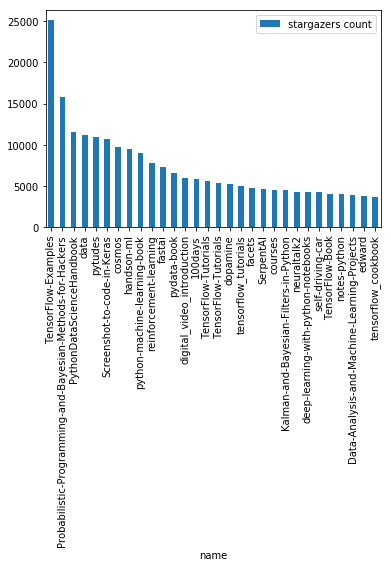

In [10]:
pd.DataFrame(df['stargazers_count'].values, index=df['name'], columns=['stargazers count']).plot(kind='bar' )

and

> **What is the mix and ratio of jupyter notebook files to other files in the repo and what can that help us understand about the actual remaining repos, and is there some pattern with this mix that leads us to understand more about the repos themselves?**

In [11]:
from collections import Counter
df_ratios = pd.DataFrame()

for u in df['url']:
    try:
        r = gh_api("{}/git/trees/master?recursive=1".format(u))

        file_list = [i['path'] for i in r['tree'] if i['type']=='blob']
        file_list_counter = Counter([f.split('/')[-1].split('.')[-1] for f in file_list])

        df_ratios = pd.concat([df_ratios, 
                   pd.DataFrame(
                       file_list_counter, 
                        columns=file_list_counter.keys(),
                        index=["{}_{}".format(u.split('/')[-2], u.split('/')[-1])])], 
                  axis=0, sort=False)
    except Exception as e:
        print("E: skipping {} / {}".format(u, e))
        
# a little cleanup to remove the NaNs
df_ratios = df_ratios.fillna(0)

E:404/b'{"message":"Not Found","documentation_url":"https://developer.github.com/v3/git/trees/#get-a-tree"}'
E: skipping https://api.github.com/repos/wesm/pydata-book / 'NoneType' object is not subscriptable


In [12]:
df_ratios

,gitignore,LICENSE,md,py,ipynb,png,csv,html,js,txt,...,Dockerfile-gpu,CNAME,csl,pandoc,stan,tpl,data-00000-of-00001,index,tfrecords,dat
aymericdamien_TensorFlow-Examples,1.0,1.0,1,33.0,33.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CamDavidsonPilon_Probabilistic-Programming-and-Bayesian-Methods-for-Hackers,1.0,0.0,8,16.0,21.0,3.0,315.0,1.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jakevdp_PythonDataScienceHandbook,2.0,0.0,4,9.0,68.0,36.0,8.0,10.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fivethirtyeight_data,1.0,1.0,122,9.0,3.0,3.0,408.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
norvig_pytudes,0.0,1.0,2,18.0,42.0,1.0,1.0,0.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
emilwallner_Screenshot-to-code-in-Keras,0.0,1.0,1,14.0,10.0,4.0,0.0,10.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OpenGenus_cosmos,2.0,1.0,435,322.0,2.0,5.0,2.0,1.0,116.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ageron_handson-ml,1.0,1.0,4,3.0,27.0,3.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rasbt_python-machine-learning-book,1.0,0.0,122,29.0,22.0,431.0,2.0,14.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dennybritz_reinforcement-learning,2.0,1.0,10,19.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here's a quick breakdown of the data by file type ... we can see **every repo** has an `.md` (guessing `README.md` or something similar), but interestingly, there is one repo without an `ipynb` (huh?).

In [13]:
df_ratios.describe().loc['count'].sort_values(ascending=False)[:30]

dat             29.0
kt              29.0
in              29.0
ts              29.0
lua             29.0
bf              29.0
hpp             29.0
rb              29.0
jl              29.0
php             29.0
cs              29.0
hs              29.0
textClipping    29.0
rs              29.0
go              29.0
c               29.0
m               29.0
data            29.0
jpeg            29.0
out             29.0
h               29.0
noneuc_500      29.0
scala           29.0
exs             29.0
purs            29.0
clj             29.0
vb              29.0
sc              29.0
elm             29.0
f               29.0
Name: count, dtype: float64

Now let's have some fun and answer the question with a picture.  We'll focus only on `ipynb` and `py` for now (everything else is `other`), but we could just as easily chosen some other mix -- and likely will when we build a deeper analysis framework.

In [14]:
# build the DF of actually ratios (we care about ipynb and py for now)
for i in df_ratios.index:
    sum = df_ratios.loc[i].sum()
    df_ratios.loc[i] = df_ratios.loc[i] / sum

# summarize
df_ratio_summary = df_ratios[['ipynb', 'py']].sort_values(by='ipynb', ascending=False)
df_ratio_summary.loc[:, 'other'] = 1 - (df_ratio_summary['ipynb'] +  df_ratio_summary['py'])

# plot
df_ratio_summary.style.background_gradient(cmap='summer')

,ipynb,py,other
coells_100days,0.953271,0,0.046729
fchollet_deep-learning-with-python-notebooks,0.904762,0,0.0952381
lijin-THU_notes-python,0.827586,0.0229885,0.149425
fastai_courses,0.533333,0.186667,0.28
dennybritz_reinforcement-learning,0.492063,0.301587,0.206349
jakevdp_PythonDataScienceHandbook,0.444444,0.0588235,0.496732
aymericdamien_TensorFlow-Examples,0.44,0.44,0.12
nlintz_TensorFlow-Tutorials,0.428571,0.428571,0.142857
norvig_pytudes,0.396226,0.169811,0.433962
ageron_handson-ml,0.375,0.0416667,0.583333


Cool!

### OBSERVATIONS

* Looks like AI, deep learning and Python are certainly hot in the "Jupyter Notebook" space for the top30
* 13% (4) of the top 30 repos are more than half `.ipynb` files
* It is confusing [SerpentAI](https://github.com/SerpentAI/SerpentAI) can up as a repo with 0 -- since it actually has ONE `ipynb` file